In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import numpy as np
import graphviz
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
X_train = pd.read_csv("../Data/Prueba_Ruxi/preprocessed_training_dataset.csv", index_col="respondent_id")
X_test = pd.read_csv("../Data/Prueba_Ruxi/preprocessed_test_dataset.csv", index_col="respondent_id")
y_train = pd.read_csv("../Data/Prueba_Ruxi/labels_train_dataset.csv", index_col="respondent_id")
y_test =  pd.read_csv("../Data/Prueba_Ruxi/labels_test_dataset.csv", index_col="respondent_id")

# Modelo sin regularización, con GridSearch


Unos solvers adecuados para modelos de regresión logisitica que no emplean la regularización son 'saga' y 'lbfgs'. Saga es especialmente interesante porque puede gestionar matrices dispersas mejor.

In [5]:
# Con balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, class_weight='balanced')
)

# Ajustar parámetros Grid Search para MultiOutputClassifier (sin regularización)
param_grid = {
    'estimator__solver': ['saga', 'lbfgs'],  # Compatible con penalty='none'
    'estimator__penalty': [None],  # Sin regularización
    'estimator__max_iter': [500, 1000, 2000],  
    'estimator__fit_intercept': [True, False],  
    'estimator__tol': [1e-3, 1e-4, 1e-5]  
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 particiones
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'},  # Métricas
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__solver', 
    'param_estimator__penalty', 
    'param_estimator__max_iter', 
    'param_estimator__tol',
    'param_estimator__fit_intercept'
]

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/Prueba_Ruxi/LogisticRegression_gridsearch_none.pkl")
print("Modelo guardado como 'LogisticRegression_gridsearch_none.pkl'")

# Guardar y ordenar resultados
results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Ruxi/logistic_gridsearch_none_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'estimator__fit_intercept': True, 'estimator__max_iter': 500, 'estimator__penalty': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.001}
Modelo guardado como 'LogisticRegression_gridsearch_none.pkl'


,mean_test_accuracy,mean_test_roc_auc,param_estimator__solver,param_estimator__penalty,param_estimator__max_iter,param_estimator__tol,param_estimator__fit_intercept
3,0.631734,0.840827,lbfgs,None,500,0.001,True
9,0.631734,0.840827,lbfgs,None,1000,0.001,True
15,0.631734,0.840827,lbfgs,None,2000,0.001,True
21,0.631734,0.840724,lbfgs,None,500,0.001,False
27,0.631734,0.840724,lbfgs,None,1000,0.001,False


In [7]:
best_model = joblib.load("../Modelos/Prueba_Ruxi/LogisticRegression_gridsearch_none.pkl")
y_pred_proba = best_model.predict_proba(X_train)
y_pred = best_model.predict(X_train)

# Calcular ROC AUC para cada label
roc_auc_scores = [
    roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
]

# Calcular Accuracy para cada label
accuracy_scores = [
    accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
]

print("Medidas de evaluación-----------------------------------------------")
print("ROC AUC Scores del mejor modelo:", roc_auc_scores)
print("Accuracy Scores del mejor modelo:", accuracy_scores, "\n")
print("Reporte de Clasificación:")
print(classification_report(y_train, y_pred, zero_division=0))

print("Probabilidades-----------------------------------------------------")
print("Primeras 5 probabilities para label 0:", y_pred_proba[0][:5, 1])
print("Primeras 5 probabilities para label 1:", y_pred_proba[1][:5, 1])

Medidas de evaluación-----------------------------------------------
ROC AUC Scores del mejor modelo: [0.8375911874024313, 0.851719878184999]
Accuracy Scores del mejor modelo: [0.780435291364381, 0.7782822373040019] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.49      0.73      0.59      4539
           1       0.76      0.77      0.76      9947

   micro avg       0.65      0.76      0.70     14486
   macro avg       0.62      0.75      0.68     14486
weighted avg       0.67      0.76      0.71     14486
 samples avg       0.35      0.37      0.35     14486

Probabilidades-----------------------------------------------------
Primeras 5 probabilities para label 0: [0.6585488  0.65123782 0.17620333 0.16206509 0.239294  ]
Primeras 5 probabilities para label 1: [0.77860049 0.66447923 0.81692876 0.11980988 0.46770531]


# Modelo con regularización l1, l2, con Grid Search

liblinear: Supports: 'l1', 'l2'
saga: Supports: 'l1', 'l2', 'elasticnet', 'none'
lbfgs: Supports: 'l2', 'none'

# Sin Balanceo

In [12]:
# Sin balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel =  MultiOutputClassifier(LogisticRegression(max_iter=1000))

# Adjustar parametros Grid Search para MultiOutputClassifier  #'liblinear', 'saga'
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],  
    'estimator__penalty': ['l1', 'l2'],            
    'estimator__solver': ['liblinear', 'saga'],   
    'estimator__max_iter': [100, 1000]            
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'}, 
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)


# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver', 
    'param_estimator__max_iter'
]

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/LogisitcRegression_gridsearch_unbalanced.pkl")
print("Modelo guardado como 'LogisitcRegression_gridsearch_unbalanced.pkl'")

results_table = results[columns].copy()
results_table.to_csv('../Results/logistic_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejores hiperparámetros: {'estimator__C': 1, 'estimator__max_iter': 100, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}
Modelo guardado como 'LogisitcRegression_gridsearch_unbalanced.pkl'


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean_test_accuracy,mean_test_roc_auc,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_estimator__max_iter
17,0.665762,0.840556,1.0,l1,saga,100
11,0.666557,0.840540,0.1,l2,saga,100
15,0.666464,0.840539,0.1,l2,saga,1000
20,0.665762,0.840516,1.0,l1,liblinear,1000
16,0.665621,0.840514,1.0,l1,liblinear,100


In [13]:
best_model = joblib.load("../Modelos/LogisitcRegression_gridsearch_unbalanced.pkl")
y_pred_proba = best_model.predict_proba(X_train)
y_pred = best_model.predict(X_train)

# Calcular ROC AUC para cada label
roc_auc_scores = [
    roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
]

# Calcular Accuracy para cada label
accuracy_scores = [
    accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
]

print("Medidas de evaluación-----------------------------------------------")
print("ROC AUC Scores del mejor modelo:", roc_auc_scores)
print("Accuracy Scores del mejor modelo:", accuracy_scores, "\n")
print("Reporte de Clasificación:")
print(classification_report(y_train, y_pred, zero_division=0))

print("Probabilidades-----------------------------------------------------")
print("Primeras 5 probabilities para label 0:", y_pred_proba[0][:5, 1])
print("Primeras 5 probabilities para label 1:", y_pred_proba[1][:5, 1])

Medidas de evaluación-----------------------------------------------
ROC AUC Scores del mejor modelo: [0.8366708385481852, 0.8519906775836614]
Accuracy Scores del mejor modelo: [0.8368827521647555, 0.7786566814884156] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.43      0.53      4539
           1       0.77      0.74      0.76      9947

   micro avg       0.75      0.64      0.69     14486
   macro avg       0.73      0.58      0.64     14486
weighted avg       0.75      0.64      0.68     14486
 samples avg       0.34      0.33      0.33     14486

Probabilidades-----------------------------------------------------
Primeras 5 probabilities para label 0: [0.35346591 0.29467975 0.05794774 0.05206922 0.08055342]
Primeras 5 probabilities para label 1: [0.75477358 0.632243   0.80161064 0.10730017 0.43815862]


# Con Balanceo

In [3]:
# Con balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel =  MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))

# Adjustar parametros Grid Search para MultiOutputClassifier
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],  
    'estimator__penalty': ['l1', 'l2'],            
    'estimator__solver': ['liblinear', 'saga'],    
    'estimator__max_iter': [100, 1000]             
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'}, 
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)


# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver', 
    'param_estimator__max_iter'
]
# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/Prueba_Ruxi/LogisitcRegression_gridsearch_balanced.pkl")
print("Modelo guardado como 'LogisitcRegression_gridsearch_balanced.pkl'")

results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Ruxi/logistic_gridsearch_balanced_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'estimator__C': 0.1, 'estimator__max_iter': 100, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
Modelo guardado como 'LogisitcRegression_gridsearch_balanced.pkl'


,mean_test_accuracy,mean_test_roc_auc,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_estimator__max_iter
8,0.632904,0.840912,0.1,l1,liblinear,100
12,0.632904,0.840911,0.1,l1,liblinear,1000
9,0.634121,0.840891,0.1,l1,saga,100
13,0.634121,0.840891,0.1,l1,saga,1000
11,0.631453,0.840852,0.1,l2,saga,100


In [9]:
best_model = joblib.load("../Modelos/LogisitcRegression_gridsearch_balanced_best_model.pkl")
y_pred_proba = best_model.predict_proba(X_train)
y_pred = best_model.predict(X_train)

# Calcular ROC AUC para cada label
roc_auc_scores = [
    roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
]

# Calcular Accuracy para cada label
accuracy_scores = [
    accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
]

print("Medidas de evaluación-----------------------------------------------")
print("ROC AUC Scores del mejor modelo:", roc_auc_scores)
print("Accuracy Scores del mejor modelo:", accuracy_scores, "\n")
print("Reporte de Clasificación:")
print(classification_report(y_train, y_pred, zero_division=0))

print("Probabilidades-----------------------------------------------------")
print("Primeras 5 probabilities para label 0:", y_pred_proba[0][:5, 1])
print("Primeras 5 probabilities para label 1:", y_pred_proba[1][:5, 1])

Medidas de evaluación-----------------------------------------------
ROC AUC Scores del mejor modelo: [0.8367029571388733, 0.8516736267465421]
Accuracy Scores del mejor modelo: [0.7783290428270536, 0.7801544582260707] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.49      0.73      0.58      4539
           1       0.76      0.77      0.77      9947

   micro avg       0.65      0.76      0.70     14486
   macro avg       0.62      0.75      0.67     14486
weighted avg       0.67      0.76      0.71     14486
 samples avg       0.35      0.38      0.35     14486

Probabilidades-----------------------------------------------------
Primeras 5 probabilities para label 0: [0.65788354 0.66590596 0.17951236 0.17306461 0.24843307]
Primeras 5 probabilities para label 1: [0.78659979 0.61197948 0.8204476  0.12049467 0.47043741]


# Bayes Search, con balanceo

In [8]:
# Envolver el modelo de regresión en MultiOutputClassifier
logistic_regression_multilabel = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))

# Definir el espacio de búsqueda de hiperparámetros
param_space = {
    'estimator__C': (1e-6, 1e+6, 'log-uniform'),  
    'estimator__penalty': ['l1', 'l2'],           
    'estimator__solver': ['liblinear', 'saga'],   
    'estimator__max_iter': (100, 1000),           
}

# Bayesian Optimization con BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=logistic_regression_multilabel,
    search_spaces=param_space,
    n_iter=50, 
    cv=5,  
    scoring='roc_auc',  # solo permite una medida
    refit=True, 
    n_jobs=-1,
    return_train_score=True
)
bayes_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", bayes_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(bayes_search.best_estimator_, "../Modelos/Prueba_Ruxi/LogisticRegression_bayes_balanced.pkl")
print("Modelo guardado como 'LogisticRegression_bayes_best_model.pkl'")

# Guardar los resultados de la búsqueda
results = pd.DataFrame(bayes_search.cv_results_)
columns = [
    'mean_test_score', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver', 
    'param_estimator__max_iter'
]
results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Ruxi/logistic_bayes_balanced_results_table.csv', index=False)

# Ordenar los resultados por ROC AUC
results_table.sort_values(by='mean_test_score', ascending=False).head(5)


Mejores hiperparámetros: OrderedDict([('estimator__C', 0.39076904491125264), ('estimator__max_iter', 1000), ('estimator__penalty', 'l1'), ('estimator__solver', 'saga')])
Modelo guardado como 'LogisticRegression_bayes_best_model.pkl'


,mean_test_score,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_estimator__max_iter
24,0.841027,0.390769,l1,saga,1000
12,0.841021,0.126839,l1,saga,756
47,0.840970,0.498861,l1,liblinear,120
2,0.840856,0.119062,l2,saga,940
44,0.840844,0.087979,l2,saga,100


In [15]:
# Modelo con Bayes Search, sin balanceo
best_model = joblib.load("../Modelos/Prueba_Ruxi/LogisticRegression_bayes_balanced.pkl")
y_pred_proba = best_model.predict_proba(X_train)
y_pred = best_model.predict(X_train)

# Calcular ROC AUC para cada label
roc_auc_scores = [
    roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
]

# Calcular Accuracy para cada label
accuracy_scores = [
    accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
]

print("Medidas de evaluación-----------------------------------------------")
print("ROC AUC Scores del mejor modelo:", roc_auc_scores)
print("Accuracy Scores del mejor modelo:", accuracy_scores, "\n")
print("Reporte de Clasificación:")
print(classification_report(y_train, y_pred, zero_division=0))

print("Probabilidades-----------------------------------------------------")
print("Primeras 5 probabilities para label 0:", y_pred_proba[0][:5, 1])
print("Primeras 5 probabilities para label 1:", y_pred_proba[1][:5, 1])

Medidas de evaluación-----------------------------------------------
ROC AUC Scores del mejor modelo: [0.8375668464076947, 0.8519070719233026]
Accuracy Scores del mejor modelo: [0.7798268195647087, 0.7799672361338638] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.49      0.74      0.59      4539
           1       0.76      0.77      0.77      9947

   micro avg       0.65      0.76      0.70     14486
   macro avg       0.62      0.75      0.68     14486
weighted avg       0.67      0.76      0.71     14486
 samples avg       0.35      0.38      0.35     14486

Probabilidades-----------------------------------------------------
Primeras 5 probabilities para label 0: [0.65676578 0.63836817 0.17977479 0.16567839 0.23883268]
Primeras 5 probabilities para label 1: [0.78187653 0.66784707 0.82117853 0.1198284  0.46495794]


# Optuna

In [12]:
import optuna
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# Objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    C = trial.suggest_float('C', 1e-6, 1e+6, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the logistic regression model
    logistic = LogisticRegression(
        max_iter=max_iter,
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight='balanced',
    )
    model = MultiOutputClassifier(logistic)
    
    # Perform cross-validation
    scorer = make_scorer(roc_auc_score, multi_class='ovo', response_method='predict_proba')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)
    return scores.mean()

# Optimize with Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Train the best model
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)
logistic = LogisticRegression(
    max_iter=best_params['max_iter'],
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    class_weight='balanced',
)
best_model = MultiOutputClassifier(logistic)
best_model.fit(X_train, y_train)

# Save the model and results
joblib.dump(best_model, "../Modelos/Prueba_Ruxi/LogisticRegression_optuna_balanced.pkl")
print("Modelo guardado como 'LogisticRegression_optuna_balanced.pkl'")



[I 2025-01-22 18:15:24,154] A new study created in memory with name: no-name-9f330529-5027-4d0d-8304-c09457dedad2
[I 2025-01-22 18:15:26,826] Trial 0 finished with value: 0.8315505871212052 and parameters: {'C': 0.011099494169420302, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 384}. Best is trial 0 with value: 0.8315505871212052.
[I 2025-01-22 18:15:31,261] Trial 1 finished with value: 0.7633961247798201 and parameters: {'C': 0.0004777438859801211, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 936}. Best is trial 0 with value: 0.8315505871212052.
[I 2025-01-22 18:16:05,094] Trial 2 finished with value: 0.8404567089413006 and parameters: {'C': 49057.64387815585, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 258}. Best is trial 2 with value: 0.8404567089413006.
[I 2025-01-22 18:16:06,788] Trial 3 finished with value: 0.8406796317584451 and parameters: {'C': 0.5240699321421122, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 617}. Best is trial 3 with value: 0.84067963175844

[I 2025-01-22 18:32:47,638] Trial 37 finished with value: 0.8404262700632058 and parameters: {'C': 29.716571088412415, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 945}. Best is trial 18 with value: 0.8410173780368737.
[I 2025-01-22 18:32:51,402] Trial 38 finished with value: 0.8196432445451126 and parameters: {'C': 0.0018436017360050662, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 667}. Best is trial 18 with value: 0.8410173780368737.
[I 2025-01-22 18:34:28,638] Trial 39 finished with value: 0.8406069059947633 and parameters: {'C': 1.150520709795898, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 578}. Best is trial 18 with value: 0.8410173780368737.
[I 2025-01-22 18:34:29,172] Trial 40 finished with value: 0.7781029300485189 and parameters: {'C': 0.00013440485751087456, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 841}. Best is trial 18 with value: 0.8410173780368737.
[I 2025-01-22 18:34:48,791] Trial 41 finished with value: 0.8407801657109986 and parameters: {'C': 0.2949

Mejores hiperparámetros: {'C': 0.12486402819496803, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 745}
Modelo guardado como 'LogisticRegression_optuna_balanced.pkl'


In [17]:
# Cargar el mejor modelo optimizado por Optuna
best_model = joblib.load("../Modelos/Prueba_Ruxi/LogisticRegression_optuna_balanced.pkl")

# Obtener las probabilidades predichas
y_pred_proba = [clf.predict_proba(X_train) for clf in best_model.estimators_]  # One for each label
y_pred = best_model.predict(X_train)

# Calcular ROC AUC para cada etiqueta
roc_auc_scores = [
    roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
]

# Calcular Accuracy para cada etiqueta
accuracy_scores = [
    accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
]

# Imprimir métricas
print("Medidas de evaluación-----------------------------------------------")
print("ROC AUC Scores del mejor modelo (Optuna):", roc_auc_scores)
print("Accuracy Scores del mejor modelo (Optuna):", accuracy_scores, "\n")
print("Reporte de Clasificación (Optuna):")
print(classification_report(y_train, y_pred, zero_division=0))

# Mostrar probabilidades para las primeras etiquetas
print("Probabilidades-----------------------------------------------------")
print("Primeras 5 probabilities para label 0 (Optuna):", y_pred_proba[0][:5, 1])
print("Primeras 5 probabilities para label 1 (Optuna):", y_pred_proba[1][:5, 1])


Medidas de evaluación-----------------------------------------------
ROC AUC Scores del mejor modelo (Optuna): [0.836937960997687, 0.8513715264029502]
Accuracy Scores del mejor modelo (Optuna): [0.7781418207348467, 0.7804820968874328] 

Reporte de Clasificación (Optuna):
              precision    recall  f1-score   support

           0       0.49      0.73      0.58      4539
           1       0.76      0.77      0.77      9947

   micro avg       0.65      0.76      0.70     14486
   macro avg       0.62      0.75      0.67     14486
weighted avg       0.67      0.76      0.71     14486
 samples avg       0.35      0.38      0.35     14486

Probabilidades-----------------------------------------------------
Primeras 5 probabilities para label 0 (Optuna): [0.65787085 0.67156795 0.17988042 0.1713633  0.24532834]
Primeras 5 probabilities para label 1 (Optuna): [0.78703883 0.67694134 0.82093055 0.11791422 0.45744617]


# Best Model - Rendimiento en Test

Medidas de evaluación-----------------------------------------------
ROC AUC Scores del mejor modelo: [0.8377278691168171, 0.8516550078076237]
Accuracy Scores del mejor modelo: [0.7824784724822164, 0.778172968925496] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.49      0.73      0.59      1135
           1       0.76      0.77      0.76      2488

   micro avg       0.65      0.76      0.70      3623
   macro avg       0.62      0.75      0.68      3623
weighted avg       0.67      0.76      0.71      3623
 samples avg       0.35      0.38      0.35      3623

Probabilidades-----------------------------------------------------
Primeras 5 probabilities para label 0: [0.10328517 0.90147843 0.14638291 0.28515047 0.35159513]
Primeras 5 probabilities para label 1: [0.63109422 0.86554437 0.15009759 0.12024264 0.41350274]


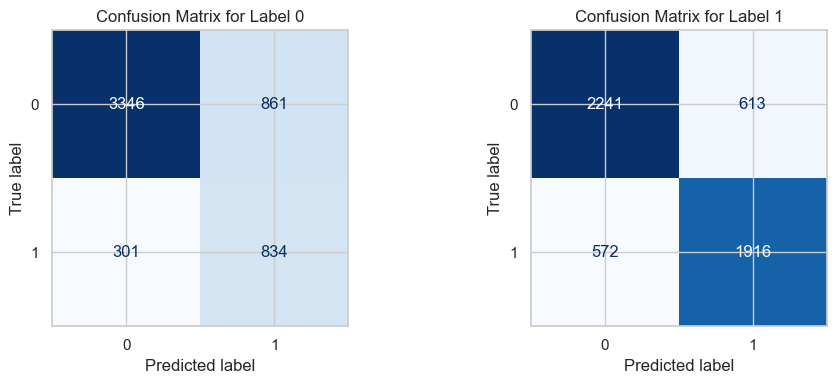

In [25]:
best_model = joblib.load("../Modelos/Prueba_Ruxi/LogisticRegression_optuna_balanced.pkl")
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Calcular ROC AUC para cada label
roc_auc_scores = [
    roc_auc_score(y_test.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_test.shape[1])
]

# Calcular Accuracy para cada label
accuracy_scores = [
    accuracy_score(y_test.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_test.shape[1])
]

print("Medidas de evaluación-----------------------------------------------")
print("ROC AUC Scores del mejor modelo:", roc_auc_scores)
print("Accuracy Scores del mejor modelo:", accuracy_scores, "\n")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Probabilidades-----------------------------------------------------")
print("Primeras 5 probabilities para label 0:", y_pred_proba[0][:5, 1])
print("Primeras 5 probabilities para label 1:", y_pred_proba[1][:5, 1])



# matriz de confusion
fig, axes = plt.subplots(1, y_test.shape[1], figsize=(10, 4), dpi=100)
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)  
    axes[i].set_title(f'Confusion Matrix for Label {i}')
plt.tight_layout()
plt.show()


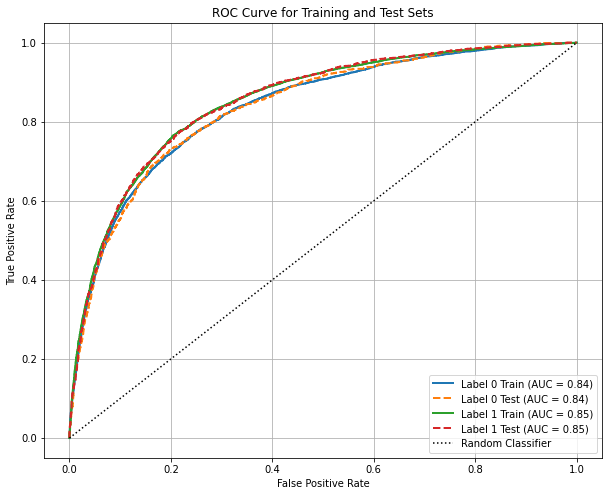

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities for both train and test sets
y_train_proba = best_model.predict_proba(X_train)
y_test_proba = best_model.predict_proba(X_test)

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(y_test.shape[1]):  # Loop through each label
    # ROC for train and test sets
    fpr_train, tpr_train, _ = roc_curve(y_train.iloc[:, i], y_train_proba[i][:, 1])
    fpr_test, tpr_test, _ = roc_curve(y_test.iloc[:, i], y_test_proba[i][:, 1])

    # Plot both curves
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Label {i} Train (AUC = {roc_auc_score(y_train.iloc[:, i], y_train_proba[i][:, 1]):.2f})')
    plt.plot(fpr_test, tpr_test, lw=2, linestyle='--', label=f'Label {i} Test (AUC = {roc_auc_score(y_test.iloc[:, i], y_test_proba[i][:, 1]):.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k:', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training and Test Sets')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Coeficientes examinados

In [22]:
X_train.shape 

(21365, 94)

In [21]:
# Get the list of logistic regression models from the MultiOutputClassifier
log_reg_models = best_model

# For each model (for each label), print the coefficients with feature names
for i, model in enumerate(log_reg_models.estimators_):  # Access the estimators_ attribute
    print(f"Coefficients for label {i}:")
    
    # Pair coefficients with feature names
    coef_names = list(zip(X_train.columns, model.coef_[0]))  # Assumes a binary classification per label (coef_ is 2D, [0] to get the array)
    
    # Sort coefficients by the absolute value (optional, for better viewing)
    coef_names_sorted = sorted(coef_names, key=lambda x: abs(x[1]), reverse=True)
    
    # Print coefficients along with their feature names
    for feature, coef in coef_names_sorted:
        print(f"{feature}: {coef:.4f}")
    
    print("\n")



Coefficients for label 0:
doctor_recc_h1n1: 2.0320
employment_industry_haxffmxo: 1.1240
employment_occupation_dcjcmpih: 1.1240
health_worker: 0.6802
opinion_h1n1_vacc_effective: 0.5853
doctor_recc_seasonal: -0.4607
opinion_h1n1_risk: 0.3538
employment_occupation_uqqtjvyb: -0.3262
employment_industry_arjwrbjb: 0.3207
employment_occupation_rcertsgn: -0.2642
behavioral_antiviral_meds: 0.2618
employment_industry_mcubkhph: -0.2505
employment_occupation_qxajmpny: -0.2491
behavioral_face_mask: 0.2353
child_under_6_months: 0.2277
employment_industry_wxleyezf: 0.2266
employment_occupation_Missing: 0.2253
sex: 0.2139
employment_occupation_hfxkjkmi: -0.2012
behavioral_large_gatherings: -0.1911
employment_industry_pxcmvdjn: -0.1746
race_Black: -0.1705
employment_occupation_cmhcxjea: 0.1570
employment_industry_fcxhlnwr: 0.1531
hhs_geo_region_lzgpxyit: -0.1507
employment_occupation_dlvbwzss: 0.1498
opinion_seas_risk: 0.1490
employment_occupation_hodpvpew: 0.1444
employment_status_Unemployed: -0.1381

Coefficients for label 0:


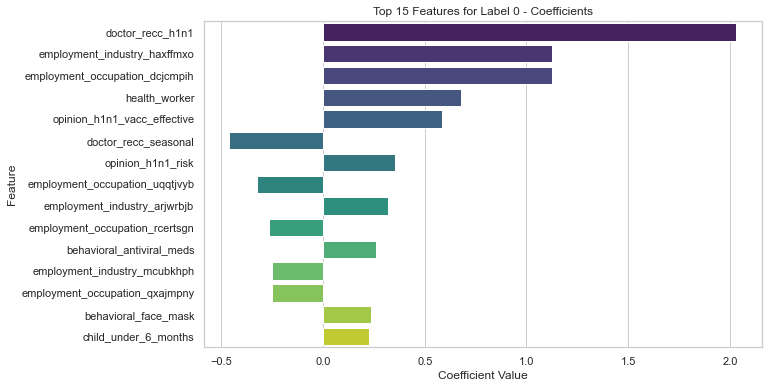



Coefficients for label 1:


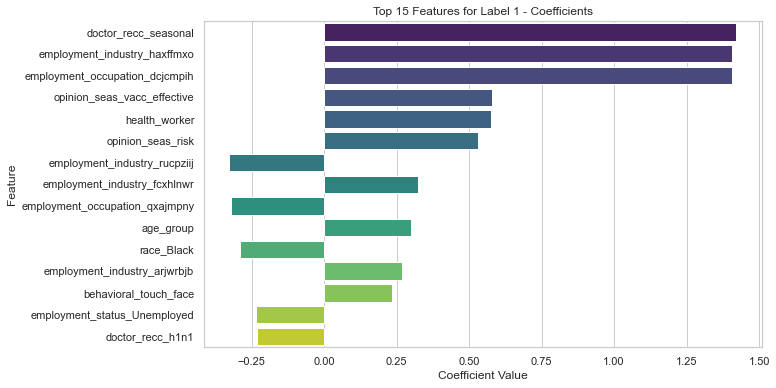

In [23]:
sns.set(style="whitegrid")

# For each model (for each label), print the coefficients and create a barplot
for i, model in enumerate(log_reg_models.estimators_):  # Access the estimators_ attribute
    print(f"Coefficients for label {i}:")
    
    # Pair coefficients with feature names
    coef_names = list(zip(X_train.columns, model.coef_[0]))  # Assumes binary classification per label (coef_ is 2D, [0] to get the array)
    
    # Sort coefficients by the absolute value (optional, for better viewing)
    coef_names_sorted = sorted(coef_names, key=lambda x: abs(x[1]), reverse=True)
    
    # Create a barplot of the top 15 coefficients
    top_15_features = coef_names_sorted[:15]
    features, coefs = zip(*top_15_features)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(coefs), y=list(features), hue=features, palette="viridis", legend=False)  # Set hue as features
    plt.title(f"Top 15 Features for Label {i} - Coefficients")
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.show()

    print("\n")

